In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
article = pd.read_csv('../data/article_info.csv')
view_log = pd.read_csv('../data/view_log.csv')

In [17]:
article_cnt = pd.DataFrame(view_log.groupby(['articleID'])['userID'].count()).reset_index()
article_cnt.columns = ['articleID', 'count']
article_cnt = article_cnt.sort_values(by='count', ascending=False)

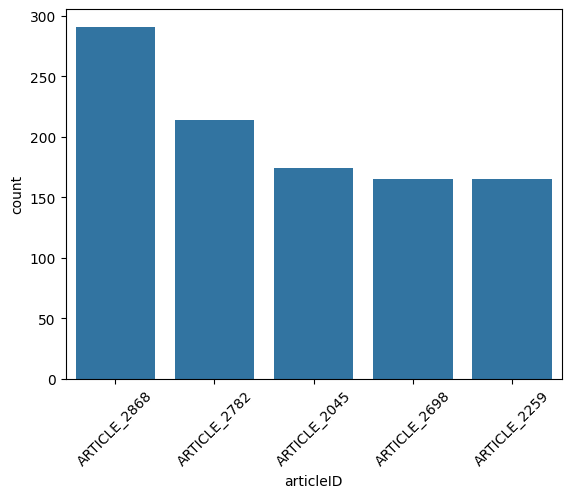

In [27]:
sns.barplot(view_log['articleID'].value_counts()[:5])
plt.xticks(rotation=45)
plt.show()

In [92]:
article.sample().T

,2496
articleID,ARTICLE_2496
Title,Machine learning is a poor fit for most busine...
Content,Machine learning is the new battle cry for the...
Format,HTML
Language,en
userID,USER_0222
userCountry,NaN
userRegion,NaN
content_len,1617
title_len,50


In [50]:
def null_values(data):
    ret = pd.DataFrame()
    ret.index = data.columns
    ROW = data.shape[0]

    null_percentage = []
    for column in ret.index:
        ncnt = data[column].isnull().sum()
        null_percentage.append(ncnt / ROW * 100)
    
    ret['null_percentage'] = null_percentage
    ret = ret.reset_index()
    ax = sns.barplot(x=ret['index'], y=ret['null_percentage'])
    plt.xticks(rotation=70)
    plt.tight_layout()

    for p in ax.patches:
        ax.annotate(f'{round(p.get_height(), 2)}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom')  # Adjust position as needed
    return ret

,index,null_percentage
0,userID,0.0
1,articleID,0.0
2,userRegion,0.0
3,userCountry,0.0


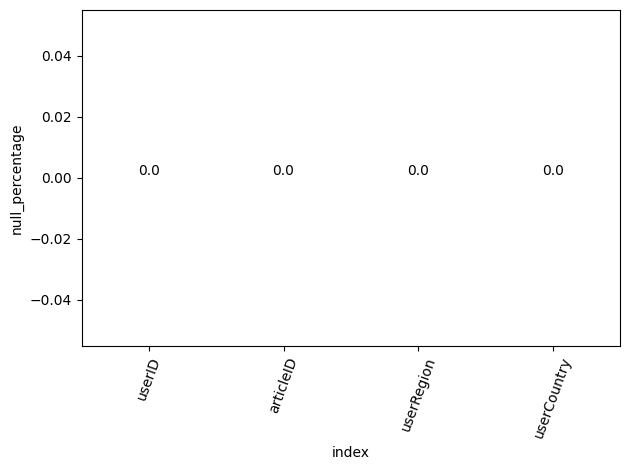

In [51]:
null_values(view_log)

# Article Info

<Axes: xlabel='Language', ylabel='count'>

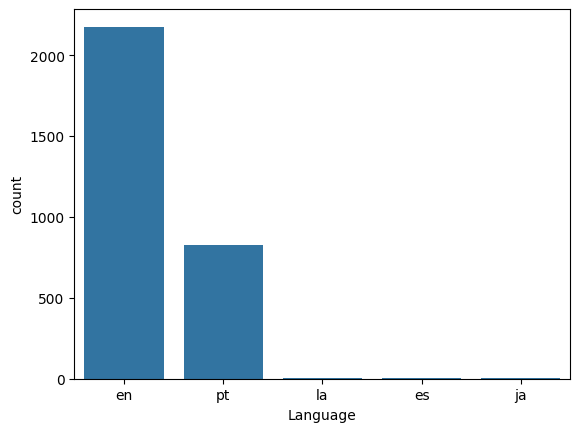

In [52]:
sns.barplot(article['Language'].value_counts())

<Axes: xlabel='Format', ylabel='count'>

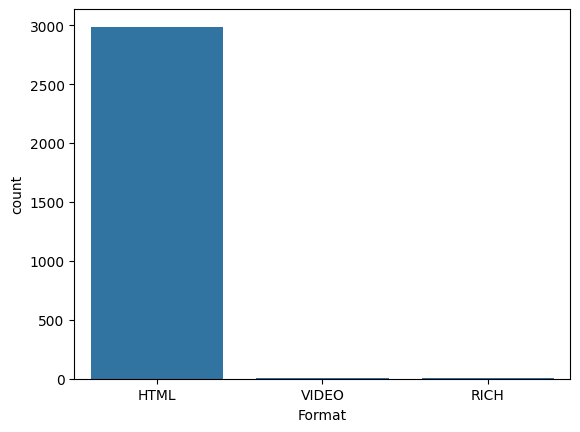

In [53]:
sns.barplot(article['Format'].value_counts())

In [54]:
pt_article = article[article['Language'] == 'pt']
la_article = article[article['Language'] == 'la']
es_article = article[article['Language'] == 'es']
jp_article = article[article['Language'] == 'ja']

In [55]:
es_article.sample().T

,524
articleID,ARTICLE_0524
Title,Costa Rica presenta su primer edificio constru...
Content,"San José, 22 abr (EFE).- Autoridades de Costa ..."
Format,HTML
Language,es
userID,USER_0704
userCountry,NaN
userRegion,NaN


<Axes: xlabel='title_len', ylabel='Count'>

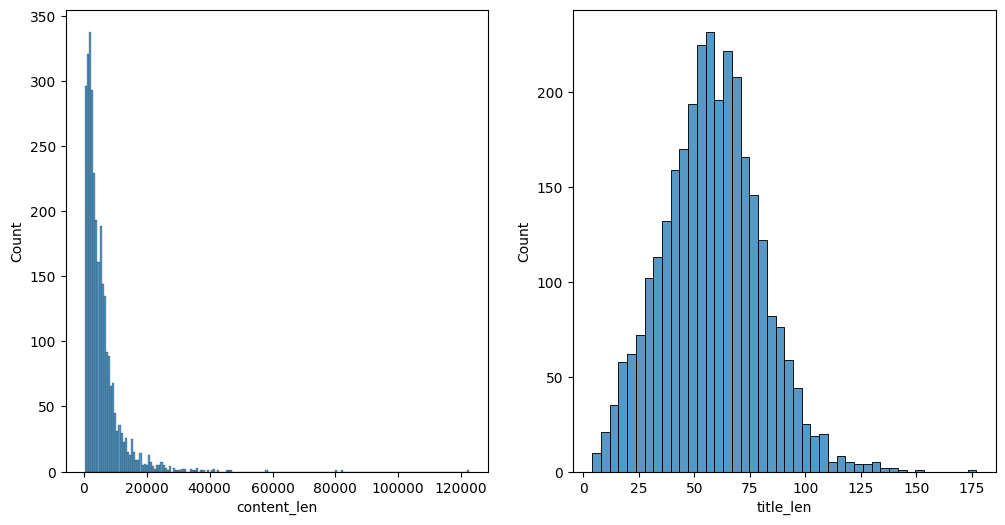

In [56]:
article['content_len'] = article['Content'].apply(len)
article['title_len'] = article['Title'].apply(len)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(article['content_len'], ax=axes[0])
sns.histplot(article['title_len'], ax=axes[1])

In [57]:
view_log_cnt = pd.DataFrame(view_log.groupby(by='articleID')['userID'].count()).reset_index()
view_log_cnt.columns = ['articleID', 'count']

In [58]:
article_meta = view_log_cnt.merge(article[['articleID', 'Format', 'Language', 'content_len', 'title_len']], on='articleID')

In [59]:
article_meta.head()

,articleID,count,Format,Language,content_len,title_len
0,ARTICLE_0000,21,HTML,en,19831,28
1,ARTICLE_0001,12,HTML,en,2165,84
2,ARTICLE_0002,6,HTML,en,15743,44
3,ARTICLE_0003,3,HTML,en,8861,77
4,ARTICLE_0004,10,HTML,en,4065,64


<Axes: >

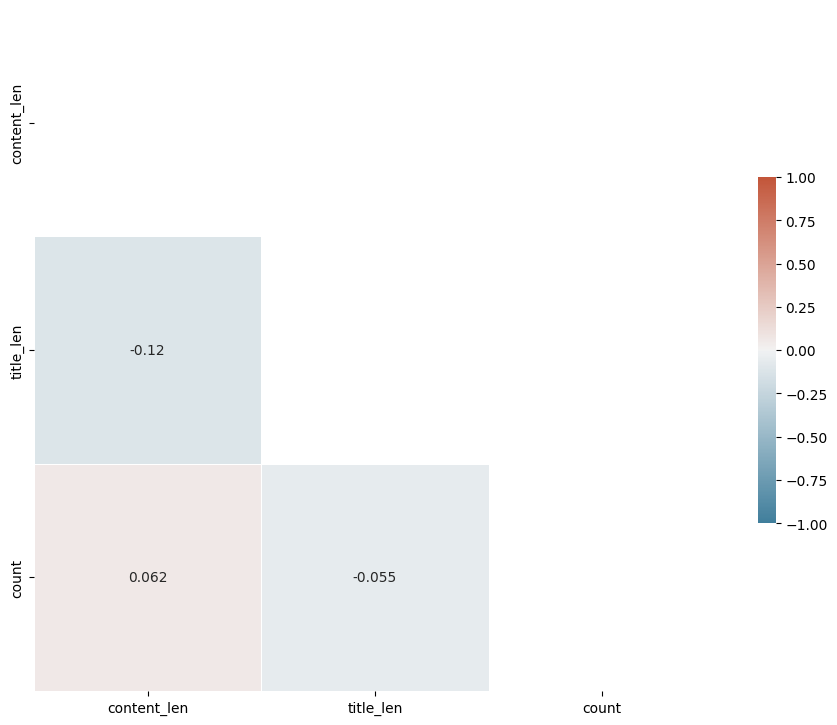

In [60]:
corr = article_meta[['content_len', 'title_len', 'count']].corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# View_log

In [61]:
lang_cnt = pd.DataFrame(article_meta['Language'].value_counts()).reset_index()
lang_cnt.columns = ['Language', 'count']

In [62]:
lang_view = pd.DataFrame(article_meta.groupby(by='Language')['count'].sum()).reset_index()
lang_view.columns = ['Language', 'view_sum']

In [63]:
lang_info = lang_view.merge(lang_cnt, on='Language')

In [64]:
lang_info['avg_view_per_lang'] = round(lang_info['view_sum'] / lang_info['count'],3)

In [86]:
lang_info

,Language,view_sum,count,avg_view_per_lang
0,en,27612,2065,13.371
1,es,6,2,3.000
2,ja,24,2,12.000
3,la,29,2,14.500
4,pt,15046,808,18.621


In [65]:
user_per_article = view_log.groupby(by='articleID')['userID'].unique().reset_index()
user_per_article.columns = ['articleID', 'viewed_users']

In [66]:
view_log.userCountry.unique()

array(['US', 'BR', 'JP', 'KR', 'CN', 'DE', 'PT', 'CO', 'AU', 'MY', 'SG',
       'CA', 'IE', 'IT', 'AR', 'CL', 'NL', 'GB', 'CH', 'ES', 'IS'],
      dtype=object)

In [67]:
import duckdb
# MEMORY 내에서만 활용
conn = duckdb.connect()

In [68]:
view_log_meta = conn.sql(f"""
with author as (
select 
    distinct(userID)
from
    article)

select
    *,
    case
        when userID in (select * from author) then 1
        else 0
    end as is_author
from
    view_log
""").df()

In [69]:
view_log_meta

,userID,articleID,userRegion,userCountry,is_author
0,USER_0000,ARTICLE_0661,NY,US,1
1,USER_0000,ARTICLE_2316,NY,US,1
2,USER_0000,ARTICLE_1345,NY,US,1
3,USER_0000,ARTICLE_1089,NY,US,1
4,USER_0000,ARTICLE_1484,NY,US,1
...,...,...,...,...,...
42712,USER_1420,ARTICLE_0682,SP,BR,1
42713,USER_1420,ARTICLE_2179,SP,BR,1
42714,USER_1420,ARTICLE_1848,SP,BR,1
42715,USER_1420,ARTICLE_0030,SP,BR,1


In [70]:
total_author = article['userID'].nunique()

In [71]:
total_author

251

In [72]:
author_per_article = view_log_meta.groupby(by='articleID')['is_author'].sum() / total_author * 100

In [73]:
author_per_article = author_per_article.reset_index()
author_per_article.columns = ['articleID', 'percentage']

<Axes: ylabel='percentage'>

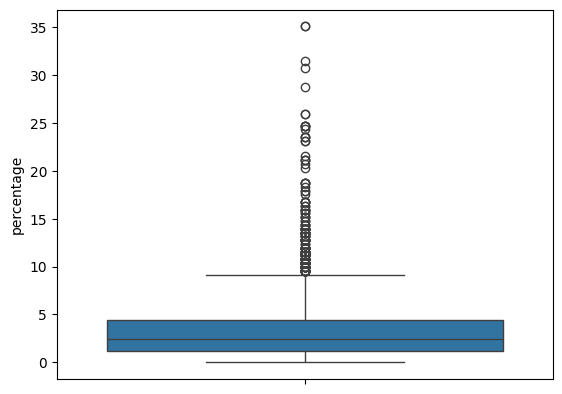

In [74]:
sns.boxplot(author_per_article['percentage'])

In [75]:
article_meta = article_meta.merge(author_per_article, on='articleID')

In [87]:
article_meta

,articleID,count,Format,Language,content_len,title_len,percentage
0,ARTICLE_0000,21,HTML,en,19831,28,3.984064
1,ARTICLE_0001,12,HTML,en,2165,84,3.585657
2,ARTICLE_0002,6,HTML,en,15743,44,1.992032
3,ARTICLE_0003,3,HTML,en,8861,77,0.796813
4,ARTICLE_0004,10,HTML,en,4065,64,2.788845
...,...,...,...,...,...,...,...
2874,ARTICLE_3003,36,HTML,pt,1988,58,4.382470
2875,ARTICLE_3004,18,HTML,en,5768,22,5.179283
2876,ARTICLE_3005,27,HTML,en,8086,68,5.976096
2877,ARTICLE_3006,58,HTML,pt,1490,67,6.772908


<Axes: >

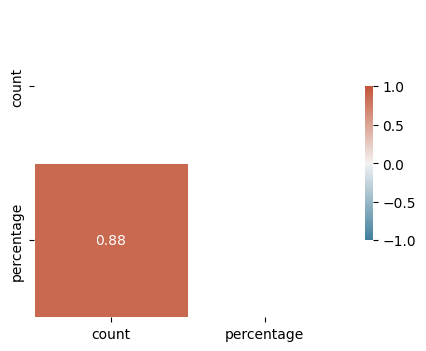

In [76]:
corr = article_meta[['count', 'percentage']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [77]:
view_log_meta

,userID,articleID,userRegion,userCountry,is_author
0,USER_0000,ARTICLE_0661,NY,US,1
1,USER_0000,ARTICLE_2316,NY,US,1
2,USER_0000,ARTICLE_1345,NY,US,1
3,USER_0000,ARTICLE_1089,NY,US,1
4,USER_0000,ARTICLE_1484,NY,US,1
...,...,...,...,...,...
42712,USER_1420,ARTICLE_0682,SP,BR,1
42713,USER_1420,ARTICLE_2179,SP,BR,1
42714,USER_1420,ARTICLE_1848,SP,BR,1
42715,USER_1420,ARTICLE_0030,SP,BR,1


In [78]:
country_counts = view_log_meta.groupby(['articleID', 'userCountry']).size().reset_index(name='count')

In [88]:
country_counts['userCountry'].value_counts()

userCountry
BR    2830
US    1402
CA     116
KR      85
AU      81
JP      68
IE      12
GB       8
IS       7
AR       5
DE       5
PT       4
SG       4
MY       2
IT       2
CO       1
CH       1
NL       1
CL       1
CN       1
ES       1
Name: count, dtype: int64

<Axes: xlabel='userCountry', ylabel='count'>

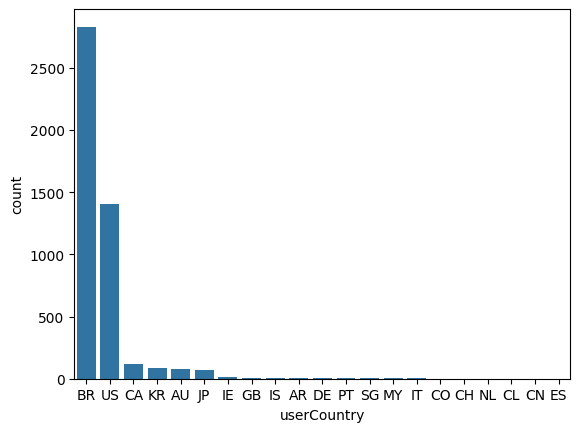

In [89]:
sns.barplot(country_counts['userCountry'].value_counts())

In [80]:
grouped = country_counts.groupby(['articleID', 'userCountry'])['count'].sum().reset_index()

# Step 2: Pivot the table to get countries as columns
pivoted = grouped.pivot(index='articleID', columns='userCountry', values='count').fillna(0)

# Step 3: Calculate the total views per article
pivoted['total_views'] = pivoted.sum(axis=1)

# Step 4: Calculate the percentage of views from Brazil
pivoted['BR_percentage'] = round((pivoted.get('BR', 0) / pivoted['total_views']) * 100, 3)

# Step 5: Display results
result = pivoted[['total_views', 'BR_percentage']].reset_index()
result.columns = ['articleID', 'total_view', 'BR_per']

In [90]:
result

,articleID,total_view,BR_per
0,ARTICLE_0000,21.0,100.000
1,ARTICLE_0001,12.0,66.667
2,ARTICLE_0002,6.0,100.000
3,ARTICLE_0003,3.0,33.333
4,ARTICLE_0004,10.0,70.000
...,...,...,...
2874,ARTICLE_3003,36.0,100.000
2875,ARTICLE_3004,18.0,94.444
2876,ARTICLE_3005,27.0,96.296
2877,ARTICLE_3006,58.0,96.552


In [81]:
grouped = country_counts.groupby(['articleID', 'userCountry'])['count'].sum().reset_index()

# Step 2: Pivot the table to get countries as columns
pivoted = grouped.pivot(index='articleID', columns='userCountry', values='count').fillna(0)

# Step 3: Calculate the total views per article
pivoted['total_views'] = pivoted.sum(axis=1)

# Step 4: Calculate the percentage of views from Brazil
pivoted['US_percentage'] = round((pivoted.get('US', 0) / pivoted['total_views']) * 100, 3)

# Step 5: Display results
us_result = pivoted[['total_views', 'US_percentage']].reset_index()
us_result.columns = ['articleID', 'total_view', 'US_per']

In [91]:
us_result

,articleID,total_view,US_per
0,ARTICLE_0000,21.0,0.000
1,ARTICLE_0001,12.0,33.333
2,ARTICLE_0002,6.0,0.000
3,ARTICLE_0003,3.0,33.333
4,ARTICLE_0004,10.0,30.000
...,...,...,...
2874,ARTICLE_3003,36.0,0.000
2875,ARTICLE_3004,18.0,5.556
2876,ARTICLE_3005,27.0,3.704
2877,ARTICLE_3006,58.0,3.448


<Axes: xlabel='US_per', ylabel='Count'>

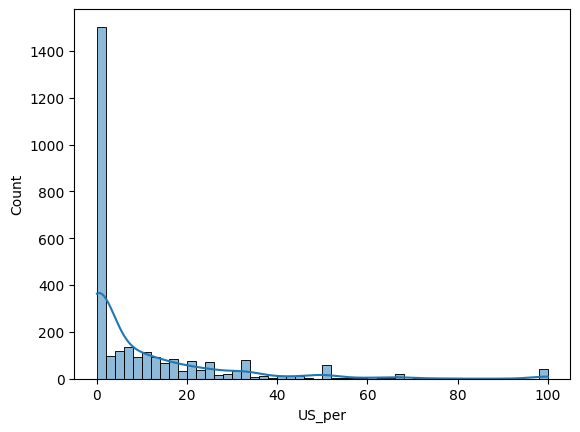

In [82]:
sns.histplot(us_result['US_per'], kde=True)

<Axes: xlabel='BR_per', ylabel='Count'>

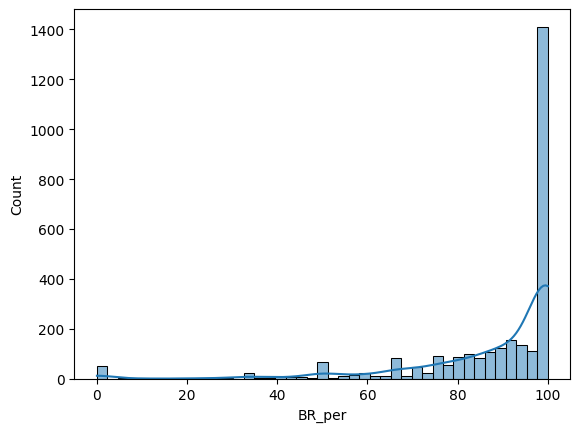

In [83]:
sns.histplot(result['BR_per'], kde=True)

<Axes: xlabel='userCountry', ylabel='count'>

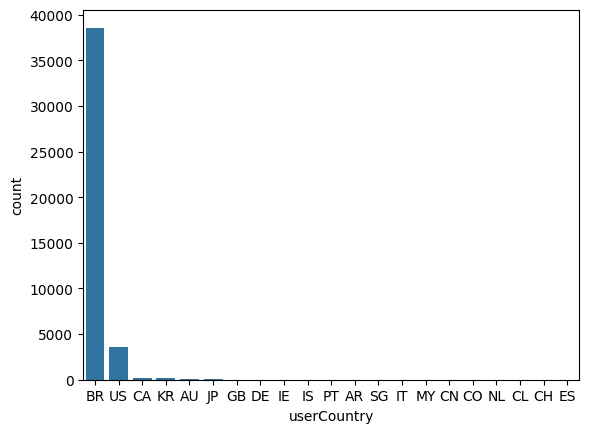

In [84]:
sns.barplot(view_log['userCountry'].value_counts())

In [85]:
view_log.describe()

,userID,articleID,userRegion,userCountry
count,42717,42717,42717,42717
unique,1415,2879,56,21
top,USER_0222,ARTICLE_2868,SP,BR
freq,974,291,30127,38566


In [95]:
emb = np.loadtxt("../cached/c_embedding")

In [98]:
np.savetxt('../cached/c_embedding.tsv', emb, delimiter='\t')